# State Classifier
This is the classifier used for the comparation between architecture

In [ ]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from google.colab import drive
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}\n")

Device is: cpu



### Here you have to change the path, where the generated embeddings are

In [ ]:
data_path = '/content/drive/MyDrive/biomedicine/embedded_data/'

# Hyper- and Controlparameter

In [ ]:
# Controlparameter

LOAD_FROM_DRIVE = False
SAVE_TO_DRIVE = False

In [ ]:
# HYPERPARAMETER

BATCH_SIZE = 128
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

# Custom Dataset & Data Preparation

In [ ]:
label_map = {
    'control': 0,
    'mild/moderate': 1,
    'severe/critical': 2,
    'progression': 1,
    'convalescence': 2,
}

In [ ]:
class EmbeddedDataset(Dataset):
    def __init__(self, pkl_file, limit=0):
        self.data = pd.read_pickle(pkl_file)


        print(self.data.head())

        unique_labels_severity = pd.unique(self.data['severity'])
        cell_types = pd.unique(self.data['celltype'])
        unique_labels_state = pd.unique(self.data['Sample time'])
        print(f"unique cell types: {cell_types}")
        label_counts = {}
        for label in self.data['severity']:
            label_counts[label] = label_counts.get(label, 0) + 1
        print(f"unique labels state: {unique_labels_state}")
        print(f"unique labels severity: {unique_labels_severity}")
        print(f"label counts: {label_counts}")
        label_counts = {}
        for label in self.data['Sample time']:
            label_counts[label] = label_counts.get(label, 0) + 1
        print(f"label counts: {label_counts}")

        if limit != 0:
            self.downsampling_celltypes(limit)
            print(f"downsampled data: {self.data.head()}")

    def cell_types_list(self):
        return list(pd.unique(self.data['celltype']))
    def distribution_cell_types(self):
        return self.data['celltype'].value_counts()

    def downsampling_celltypes(self, limit):
        cell_types = self.cell_types_list()
        downsampled_data = pd.DataFrame()
        for cell_type in cell_types:
            cell_type_data = self.data[self.data['celltype'] == cell_type]

            if len(cell_type_data) >= limit:
                label_counts = cell_type_data['severity'].value_counts()
                min_count = label_counts.min()
                sampled_data = pd.DataFrame()
                for label in label_counts.index:
                    label_data = cell_type_data[cell_type_data['severity'] == label]
                    sampled_label_data = label_data.sample(n=min( int(limit/3), min_count), random_state=42)
                    sampled_data = pd.concat([sampled_data, sampled_label_data])
                    downsampled_data = pd.concat([downsampled_data, sampled_label_data])

                #downsampled_data = pd.concat([downsampled_data, cell_type_data])
        self.data = downsampled_data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32)
        label_state = torch.tensor(label_map.get(self.data.iloc[idx, 1]), dtype=torch.long)
        label_severity = torch.tensor(label_map.get(self.data.iloc[idx, 3]), dtype=torch.long)
        cell_type = self.data.iloc[idx, 2]

        return embeddings, label_severity, label_state, cell_type

### Here can you configure the number that will be used as limit for the creation of the balanced dataset

In [ ]:
dataset = EmbeddedDataset(os.path.join(data_path, 'embedded_data_split_severity_celltype_progression_all.pkl'), 3000)


                                          embeddings       severity  \
0  [0.05455078, -0.003437997, -0.023250412, -0.02...  mild/moderate   
1  [0.022801453, -0.025798667, 0.0002587465, 0.00...  mild/moderate   
2  [0.04894136, -0.0035773313, -0.030182272, -0.0...  mild/moderate   
3  [0.035008512, -0.020082857, 0.007999258, 0.009...  mild/moderate   
4  [0.038176414, -0.006059695, -0.029966526, -0.0...  mild/moderate   

                celltype    Sample time  
0  Mono_c2-CD14-HLA-DPB1  convalescence  
1        T_CD8_c08-IL2RB  convalescence  
2      Mono_c3-CD14-VCAN  convalescence  
3        T_CD4_c04-ANXA2  convalescence  
4      Mono_c3-CD14-VCAN  convalescence  
unique cell types: ['Mono_c2-CD14-HLA-DPB1' 'T_CD8_c08-IL2RB' 'Mono_c3-CD14-VCAN'
 'T_CD4_c04-ANXA2' 'Mono_c1-CD14-CCL3' 'Mono_c5-CD16' 'T_CD8_c07-TYROBP'
 'Mono_c4-CD14-CD16' 'T_CD4_c07-AHNAK' 'T_CD4_c12-FOXP3' 'B_c01-TCL1A'
 'T_CD4_c01-LEF1' 'T_CD4_c11-GNLY' 'T_CD4_c03-ITGA4' 'T_CD8_c05-ZNF683'
 'B_c03-CD27-AIM2' 'T_C

In [ ]:
dataset.distribution_cell_types()

,count
celltype,
Mono_c2-CD14-HLA-DPB1,3000
T_CD4_c06-NR4A2,3000
T_CD4_c05-FOS,3000
T_CD4_c09-GZMK-FOS_l,3000
T_CD8_c09-SLC4A10,3000
DC_c2-CD1C,3000
T_CD8_c06-TNF,3000
NK_c01-FCGR3A,3000
T_CD8_c03-GZMK,3000


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
for (embeddings, labels_severity,labels_state,_) in train_loader:
    print(type(embeddings[0]))
    print(type(labels_severity[0]))
    print(type(embeddings[0][0]))
    print(type(labels_severity[0].item()))
    print(type(labels_state[0].item()))
    print(labels_severity)
    print(labels_state)
    break
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'int'>
<class 'int'>
tensor([2, 1, 1, 0, 1, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 1, 0,
        1, 2, 0, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 1, 1, 2, 1, 2, 0,
        2, 2, 1, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1,
        2, 1, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 1, 1, 2, 2, 2])
tensor([2, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0,
        1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 1, 0,
        1, 2, 2, 1, 1, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1,
        1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 2, 2, 2, 2, 2, 1, 2])


# Model Architecture


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# MultiTask Classifier Model
class MultiTaskClassifier(nn.Module):
    def __init__(self):
        super(MultiTaskClassifier, self).__init__()

        # Shared layers for feature extraction
        self.shared_layers = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
        )

        # Head 1: Classification (Control, Mild, Severe)
        self.disease_severity_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 3)  # 3 classes: Control, Mild, Severe
        )

        # Head 2: Classification (Control, Progression, Convalescence)
        self.disease_state_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 3)  # 3 classes: Control, Progression, Convalescence
        )

    def forward(self, x):
        shared_features = self.shared_layers(x)
        severity_output = self.disease_severity_head(shared_features)  # Raw logits (not softmaxed)
        state_output = self.disease_state_head(shared_features)  # Raw logits (not softmaxed)
        return severity_output, state_output


In [ ]:
def train(model, train_loader, num_epochs, optimizer, criterion):
    model.to(device)  # Move model to device
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        dataloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (embeddings, severity_labels, state_labels, _) in enumerate(dataloader):
            embeddings = embeddings.to(device)
            severity_labels = severity_labels.to(device).long()  # Labels: 0=Control, 1=Mild, 2=Severe
            state_labels = state_labels.to(device).long()  # Labels: 0=Control, 1=Progression, 2=Convalescence

            optimizer.zero_grad()
            severity_output, state_output = model(embeddings)  # Forward pass

            # Compute losses
            loss_severity = criterion(severity_output, severity_labels)  # CrossEntropy for 3 classes
            loss_state = criterion(state_output, state_labels)  # CrossEntropy for 3 classes
            loss = loss_severity + loss_state  # Combined loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            dataloader.set_postfix({"Loss": running_loss / (i + 1)})  # Show avg loss per batch


In [ ]:
# Initialize model
model = MultiTaskClassifier().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()  # Suitable for both 3-class classification tasks

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
train(model, train_loader, num_epochs=10, optimizer=optimizer, criterion=criterion)


Epoch 10/10: 100%|██████████| 633/633 [03:03<00:00,  3.44it/s, Loss=0.555]


# Training

In [ ]:
# start training loop
#if not LOAD_FROM_DRIVE:
#    train(
#        model=classifier_model,
#        train_loader=train_loader,
#        num_epochs=NUM_EPOCHS,
#        optimizer=optimizer,
#        criterion=criterion
#    )

# Evaluation

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from tqdm import tqdm
import numpy as np
def evaluate(model, test_loader):
    model.eval()
    all_preds_severity = []
    all_labels_severity = []
    all_preds_state = []
    all_labels_state = []

    cell_type_results_severity = defaultdict(lambda: {"y_true": [], "y_pred": []})
    cell_type_results_state = defaultdict(lambda: {"y_true": [], "y_pred": []})

    with torch.no_grad():
        for embeddings, labels_severity, labels_state, cell_types in test_loader:
            embeddings = embeddings.to(device)
            labels_severity = labels_severity.to(device)
            labels_state = labels_state.to(device)

            outputs_severity, outputs_state = model(embeddings)  # Multitask output
            preds_severity = torch.argmax(outputs_severity, dim=1)
            preds_state = torch.argmax(outputs_state, dim=1)

            all_preds_severity.extend(preds_severity.cpu().numpy())
            all_labels_severity.extend(labels_severity.cpu().numpy())

            all_preds_state.extend(preds_state.cpu().numpy())
            all_labels_state.extend(labels_state.cpu().numpy())

            for i, cell in enumerate(cell_types):
                cell_type_results_severity[cell]["y_true"].append(labels_severity[i].item())
                cell_type_results_severity[cell]["y_pred"].append(preds_severity[i].item())

                cell_type_results_state[cell]["y_true"].append(labels_state[i].item())
                cell_type_results_state[cell]["y_pred"].append(preds_state[i].item())

    # Compute metrics for severity and state tasks
    accuracy_severity = accuracy_score(all_labels_severity, all_preds_severity)
    precision_severity = precision_score(all_labels_severity, all_preds_severity, average="macro")
    recall_severity = recall_score(all_labels_severity, all_preds_severity, average="macro")
    f1_severity = f1_score(all_labels_severity, all_preds_severity, average="macro")

    accuracy_state = accuracy_score(all_labels_state, all_preds_state)
    precision_state = precision_score(all_labels_state, all_preds_state, average="macro")
    recall_state = recall_score(all_labels_state, all_preds_state, average="macro")

    # Confusion matrix for severity
    cm_severity = confusion_matrix(all_labels_severity, all_preds_severity)
    cm_severity_normalized = cm_severity.astype('float') / cm_severity.sum(axis=1)[:, np.newaxis]

    # Confusion matrix for state
    cm_state = confusion_matrix(all_labels_state, all_preds_state)
    cm_state_normalized = cm_state.astype('float') / cm_state.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix for severity
    sns.heatmap(cm_severity_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=["control", "mild", "severe"],
                yticklabels=["control", "mild", "severe"], ax=axes[0], cbar=False)
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")
    axes[0].set_title("Confusion Matrix - Severity")

    # Plot confusion matrix for state
    sns.heatmap(cm_state_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=["control", "progression", "convalescence"],
                yticklabels=["control", "progression", "convalescence"], ax=axes[1], cbar=False)
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")
    axes[1].set_title("Confusion Matrix - State")

    plt.tight_layout()
    plt.show()

    # Compute cell type performance
    cell_type_list, acc_sev, f1_sev, acc_state, f1_state = [], [], [], [], []

    for cell, values in cell_type_results_severity.items():
        acc_sev.append(accuracy_score(values["y_true"], values["y_pred"]))
        f1_sev.append(f1_score(values["y_true"], values["y_pred"], average="macro"))
        cell_type_list.append(cell)

    for cell, values in cell_type_results_state.items():
        acc_state.append(accuracy_score(values["y_true"], values["y_pred"]))
        f1_state.append(f1_score(values["y_true"], values["y_pred"], average="macro"))

    cell_results_severity = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy_Severity": acc_sev,
        "F1-score_Severity": f1_sev
    })

    cell_results_state = pd.DataFrame({
        "Cell Type": cell_type_list,
        "Accuracy_State": acc_state,
        "F1-score_State": f1_state
    })
    f1_state = f1_score(all_labels_state, all_preds_state, average="macro")


    # Return results
    return accuracy_severity, precision_severity, recall_severity, f1_severity, accuracy_state, precision_state, recall_state, f1_state, cell_results_severity, cell_results_state


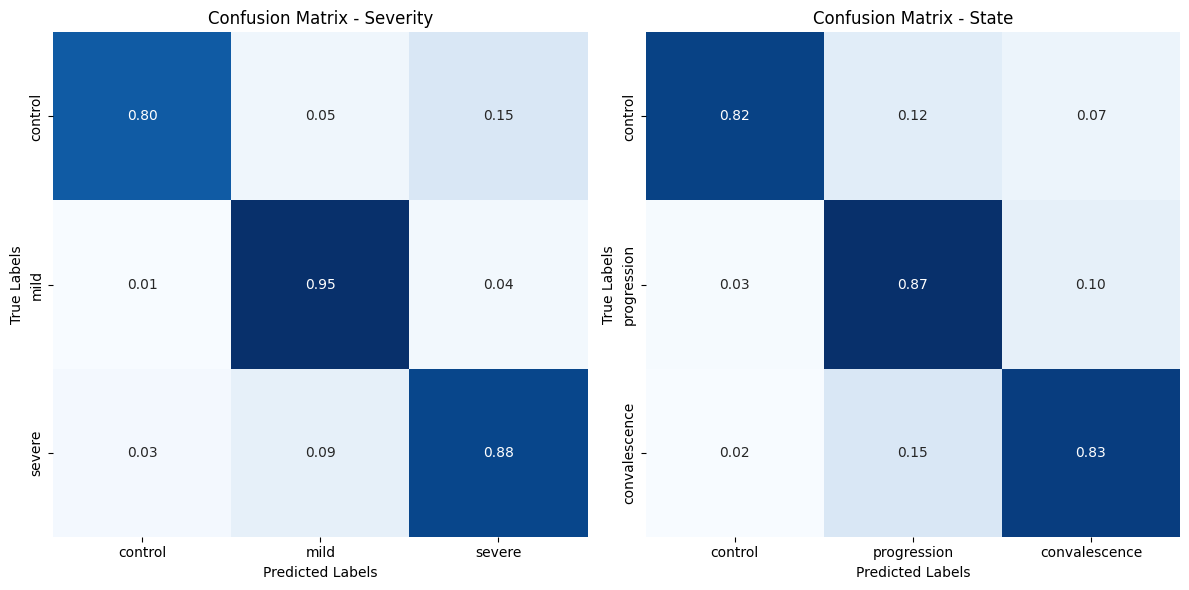

(0.8735109485443132,
 0.8791502003752291,
 0.8763914447247464,
 0.8743832664606717,
 0.8396025900845238,
 0.8484493382663368,
 0.8393600092095541,
 0.8412847923429291,
                 Cell Type  Accuracy_Severity  F1-score_Severity
 0           T_CD8_c06-TNF           0.871753           0.872131
 1       Mono_c3-CD14-VCAN           0.909091           0.910942
 2              DC_c2-CD1C           0.869347           0.871919
 3    T_CD4_c09-GZMK-FOS_l           0.895149           0.895875
 4         T_CD4_c12-FOXP3           0.895447           0.895629
 5        T_CD8_c02-GPR183           0.850498           0.848985
 6       T_CD8_c09-SLC4A10           0.851351           0.852440
 7          T_CD4_c11-GNLY           0.872414           0.874881
 8     B_c04-SOX5-TNFRSF1B           0.891170           0.880684
 9         B_c05-MZB1-XBP1           0.845304           0.844723
 10      Mono_c1-CD14-CCL3           0.893401           0.893035
 11       B_c02-MS4A1-CD27           0.822606       

In [ ]:
evaluate(model, test_loader)

In [ ]:
import pandas as pd
from collections import Counter

def compare_cell_type_distribution(dataset, train_loader, test_loader):
    # Get total distribution from dataset (assuming it's a DataFrame)
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Total Count"]

    # Initialize counters for train and test sets
    train_counter = Counter()
    test_counter = Counter()

    # Count occurrences of each cell type in training set
    for _, _, _, cell_types in train_loader:
        train_counter.update(cell_types)

    # Count occurrences of each cell type in test set
    for _, _, _, cell_types in test_loader:
        test_counter.update(cell_types)

    # Convert counters to Pandas Series
    train_series = pd.Series(train_counter, name="Train Count")
    test_series = pd.Series(test_counter, name="Test Count")

    # Create a DataFrame with all distributions
    df = total_distribution.set_index("Cell Type").join([train_series, test_series]).fillna(0)

    # Convert counts to integers
    df = df.astype(int)

    return df


In [ ]:
compare_cell_type_distribution(dataset, train_loader, test_loader)


### For futher analysis of the data, we created additionally function to observe to compute the correlation between the number of samples of cell types and their respective f1-score and accuracy

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_correlation(dataset, train_loader, test_loader, model):
    # Step 1: Get dataset distribution
    total_distribution = dataset.distribution_cell_types()

    # Ensure it's a DataFrame
    if isinstance(total_distribution, pd.Series):
        total_distribution = total_distribution.reset_index()
        total_distribution.columns = ["Cell Type", "Train Count"]

    # Step 2: Evaluate model performance per cell type for both tasks
    cell_results_severity, cell_results_state, _, _, _, _ = evaluate(model, test_loader)

    # Step 3: Merge both performance DataFrames
    merged_df = total_distribution.merge(cell_results_severity, on="Cell Type", how="inner")
    merged_df = merged_df.merge(cell_results_state, on="Cell Type", how="inner", suffixes=("_Severity", "_State"))

    # Step 4: Compute correlations
    correlation_results = {
        "Accuracy_Severity": pearsonr(merged_df["Train Count"], merged_df["Accuracy_Severity"])[0],
        "F1-score_Severity": pearsonr(merged_df["Train Count"], merged_df["F1-score_Severity"])[0],
        "Accuracy_State": pearsonr(merged_df["Train Count"], merged_df["Accuracy_State"])[0],
        "F1-score_State": pearsonr(merged_df["Train Count"], merged_df["F1-score_State"])[0],
    }

    # Step 5: Visualization
    plt.figure(figsize=(12, 10))

    # Scatter Plot: Frequency vs Accuracy (Severity)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy_Severity"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy (Severity)")
    plt.title(f"Correlation: {correlation_results['Accuracy_Severity']:.4f}")

    # Scatter Plot: Frequency vs F1-score (Severity)
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score_Severity"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score (Severity)")
    plt.title(f"Correlation: {correlation_results['F1-score_Severity']:.4f}")

    # Scatter Plot: Frequency vs Accuracy (State)
    plt.subplot(2, 2, 3)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["Accuracy_State"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("Accuracy (State)")
    plt.title(f"Correlation: {correlation_results['Accuracy_State']:.4f}")

    # Scatter Plot: Frequency vs F1-score (State)
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=merged_df["Train Count"], y=merged_df["F1-score_State"])
    plt.xlabel("Train Count of Cell Type")
    plt.ylabel("F1-score (State)")
    plt.title(f"Correlation: {correlation_results['F1-score_State']:.4f}")

    plt.tight_layout()
    plt.show()

    # Print correlation results
    print("Correlation between Cell Type Frequency and Performance:")
    print(f"  Accuracy (Severity) Correlation: {correlation_results['Accuracy_Severity']:.4f}")
    print(f"  F1-score (Severity) Correlation: {correlation_results['F1-score_Severity']:.4f}")
    print(f"  Accuracy (State) Correlation: {correlation_results['Accuracy_State']:.4f}")
    print(f"  F1-score (State) Correlation: {correlation_results['F1-score_State']:.4f}")

    return merged_df, correlation_results


In [ ]:
df_analysis, correlation = analyze_correlation(dataset, train_loader, test_loader, model)